In [7]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy import stats
from scipy.stats import zscore
from math import radians, cos, sin, asin, sqrt
import pydot
import seaborn as sns
import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, layers, models
import os, shutil
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
!pip install category_encoders
import category_encoders as ce

     |████████████████████████████████| 86 kB 2.9 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
# load in data 
url = 'https://raw.githubusercontent.com/rindalafayyad17/263-Project/main/diabetes_012_health_indicators_BRFSS2015.csv'
diabetes = pd.read_csv(url)


In [9]:
diabetes.shape

(253680, 22)

In [10]:
diabetes.head()


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


We will need several preprocessing steps: 

0. Remove missing rows. We have tons of data so lets just try to drop any rows with NA values. **Turns out there are no missing values**

1. Identify the continuous and catgeorical variables. 

2. Continuous vairables need to be normalized, that is subtract mean and divide by standard deviation. Look at SCM class notes for assistance as sklearn should have package to do this. '

3. Categorical variables will need to be encoded appropriately. 

Continuous variables: 
- BMI, MentHlth, PhysHlth


Categorical Variables:

*Binary:* 
- HighBp, HighCl, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsumption, AnyHealthcare, NoDocbcCost, GenHlth, DiffWalk, Sex

*Ordinal*

- Age, Education, Income

In [11]:
#using category encoders instead
ce_OHE = ce.OneHotEncoder(cols=['Age','Education', 'Income'])

diabetes_final = ce_OHE.fit_transform(diabetes)
print(diabetes_final.head())
diabetes_final.shape

   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1           0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2           0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3           0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4           0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  Education_5  Education_6  \
0                   0.0           0.0     0.0  ...            0            0   
1                   0.0           1.0     0.0  ...            0            0   
2                   0.0           0.0     1.0  ...            0            0   
3                   0.0           1.0     1.0  ...            0            0   
4                   0.0           1.0     1.0  ...            0            0   

   Income_1  Income_2  Income_3  Income_4  Income_5  Income_6  Income_7  \
0         1         0  

(253680, 46)

In [12]:
# need to make training, validation and test split
features = diabetes_final.drop('Diabetes_012', axis = 1)

# reshape labels and encode them
ce_OHE = ce.OneHotEncoder(cols=['Diabetes_012'])
labels = ce_OHE.fit_transform(diabetes_final)
labels = labels.iloc[:,0:3]

In [13]:
labels.head()

,Diabetes_012_1,Diabetes_012_2,Diabetes_012_3
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [14]:
features.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,Education_5,Education_6,Income_1,Income_2,Income_3,Income_4,Income_5,Income_6,Income_7,Income_8
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0


In [15]:
# split into training and testing set 
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(features, labels,
    test_size=0.2, shuffle = True, random_state = 356)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 356) # 0.25 x 0.8 = 0.2

In [16]:
# build and compile model 
# Define model
model = keras.Sequential([
  layers.Dense(256, activation='relu', input_dim = 45),
  
  layers.Dense(128, activation='sigmoid'), 
  layers.Dropout(0.5),

  layers.Dense(32, activation='sigmoid'), 

  layers.Dense(3, activation='softmax') # 3 categories
])

# model compile function
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(),
              metrics = ['accuracy'])

In [18]:
history = model.fit(X_train, 
          y_train, 
          epochs = 200, 
          batch_size = 50,
          validation_data=(X_val, y_val)
          )

Epoch 1/200
3045/3045 [==============================] - 22s 7ms/step - loss: 0.4280 - accuracy: 0.8421 - val_loss: 0.4237 - val_accuracy: 0.8466
Epoch 2/200
3045/3045 [==============================] - 19s 6ms/step - loss: 0.4286 - accuracy: 0.8424 - val_loss: 0.4208 - val_accuracy: 0.8420
Epoch 3/200
3045/3045 [==============================] - 16s 5ms/step - loss: 0.4287 - accuracy: 0.8425 - val_loss: 0.4227 - val_accuracy: 0.8420
Epoch 4/200
3045/3045 [==============================] - 18s 6ms/step - loss: 0.4297 - accuracy: 0.8424 - val_loss: 0.4189 - val_accuracy: 0.8420
Epoch 5/200
3045/3045 [==============================] - 9s 3ms/step - loss: 0.4289 - accuracy: 0.8422 - val_loss: 0.4289 - val_accuracy: 0.8420
Epoch 6/200
3045/3045 [==============================] - 9s 3ms/step - loss: 0.4304 - accuracy: 0.8423 - val_loss: 0.4319 - val_accuracy: 0.8420
Epoch 7/200
3045/3045 [==============================] - 9s 3ms/step - loss: 0.4324 - accuracy: 0.8424 - val_loss: 0.4367 - va

In [21]:
# save model
model.save("diabetes.h5")

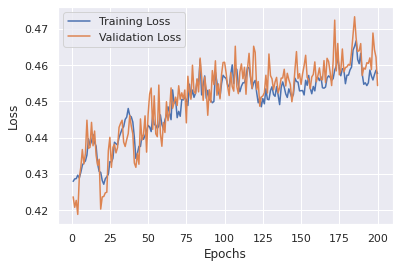

In [19]:
# plot of validation loss and train loss
import seaborn as sns
sns.set()

train_acc  = history.history['accuracy']
train_loss = history.history['loss']
val_acc  = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [20]:
# test set accuracy 
test_loss, test_acc = model.evaluate(X_test, y_test)
print("The test set accuracy is: ", test_acc)

1586/1586 [==============================] - 4s 3ms/step - loss: 0.4550 - accuracy: 0.8414
The test set accuracy is:  0.8413552641868591
